In [1]:
import tensorflow as tf
import pathlib
import os, sys
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from rimworld.utils import read_metadata #one_hot_encodene_hot_encode




In [2]:
model = tf.keras.models.load_model('instrument_and_pitch_single_label_model_1621692125')

In [3]:
ROOT_FOLDER = r"C:\Users\david.isaacspaternos\broncode\data\stft"

# label_dir = r"D:\Projects\nsynth-data\data/nsynth-test"
# test_jsondata = read_metadata(label_dir).sort_index()
# test_labels = test_jsondata.instrument_family

In [18]:
BATCH_SIZE = 128
img_height = 126
img_width = 1025
LABEL = 'instrument_and_pitch_single_label'

def get_label(filename, label_type, label_size):
    switch = {
        "instrument": get_instrument_label,
        "instrument_subtype": get_instrument_subtype_label,
        "pitch": get_pitch_label,
        "multi": get_multi_label,
        "instrument_and_pitch_single_label": get_instrument_and_pitch,
    }
    sparse_label = switch[label_type](filename)
    #these arent really sparse, just funky code (should hire cleaner)
    if label_type == "multi" or label_type == "instrument_and_pitch_single_label":  
        return sparse_label
    
    label = np.zeros((label_size, 1))
    label[sparse_label] = 1
    return label

def get_instrument_label(filename):
    instrument = "_".join(filename.split('_')[:-2])
    switch = {
        'bass': 0,
        'brass': 1,
        'flute': 2,
        'guitar': 3,
        'keyboard': 4,
        'mallet': 5,
        'organ': 6,
        'reed': 7,
        'string': 8,
        'synth_lead': 9,
        'vocal': 10,
    }
    return switch[instrument]

def get_instrument_subtype_label(filename):
    instrument_label = get_instrument_label(filename)
    subtype = filename.split('_')[-2]
    switch = {
        "acoustic": 0,
        "electronic": 1,
        "synthetic": 2
    }
    label = instrument_label * len(switch) + switch[subtype]
    return label


def get_pitch_label(filename):
    label = int(filename.split('-')[1])
    return label

import time
def get_multi_label(filename):
    """ multi label with best recognizable instruments
        bass_electronic, vocal acoustic, organ electronic, string acoustic, other_instruments, noise(when added to dataset), pitch """
    pitch_label = get_pitch_label(filename)
    instrument_label = get_instrument_subtype_label(filename)

    if instrument_label == 1:
        instrument_label = 0      #"bass_electronic"
    elif instrument_label == 19:
        instrument_label = 1      #"organ_electronic"
    elif instrument_label == 24:
        instrument_label = 2      #"string_acoustic"
    elif instrument_label == 30:
        instrument_label = 3      #"vocal_acoustic"
    else:
        instrument_label = 4      #"other"

    label = np.zeros(5+112) # 5 for instruments, 112 for pitches, lowest = 9, highest is 120 (check vocal synthetic, it has them both)
    label[instrument_label] = 1
    try:
        label[pitch_label+5-9] = 1    # +5 because first 5 are instruments, -9 because 009 is the lowest pitch in the nsynth dataset
    except:        
        print(filename)
        print(label)
        time.sleep(10)
        
    return label  

def get_instrument_and_pitch(filename):
    pitch_label = get_pitch_label(filename)
    instrument_label = get_instrument_subtype_label(filename)

    if instrument_label == 1:
        instrument_label = 0      #"bass_electronic"
    elif instrument_label == 19:
        instrument_label = 1      #"organ_electronic"
    elif instrument_label == 24:
        instrument_label = 2      #"string_acoustic"
    elif instrument_label == 30:
        instrument_label = 3      #"vocal_acoustic"
    else:
        instrument_label = 4      #"other"
        
    label = np.zeros(5*112)
    label[instrument_label*112 + pitch_label-9] = 1
#     print(filename)
#     print(np.argmax(label))
#     time.sleep(10)
    
    return label


def reset(batch_size, label_size):
    imgs = np.zeros((batch_size, 126, 1025, 1))
    labels = np.zeros((batch_size, label_size))
    return imgs, labels


def get_dataset(path, label_type, label_size, batch_size):
    filenames = [f for r, d, fs in os.walk(path) for f in fs]  # tf uses os.walk to determine file order
    labels = [get_label(filename, label_type, label_size) for filename in filenames]
    dataset = tf.keras.preprocessing \
        .image_dataset_from_directory(
            directory=path,
            labels=labels,
            color_mode='grayscale',
            batch_size=batch_size,
            image_size=(126, 1025),
            shuffle=False
        )
    return dataset

label_shapes = dict(
    instrument=1,
    instrument_subtype=33,
    pitch=128,
    instrument_subtype_and_pitch=5+112,
    instrument_and_pitch_single_label=5*112,
    # 4 instruments, 1 other, 112 pitches
)

train_folder = os.path.join(ROOT_FOLDER, 'train')

valid_folder = os.path.join(ROOT_FOLDER, 'valid')

test_folder = os.path.join(ROOT_FOLDER, 'test')

test_ds = get_dataset(valid_folder, LABEL, label_shapes[LABEL], BATCH_SIZE)


Found 12678 files belonging to 1 classes.


In [75]:
import time
import pandas as pd
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    #print(x)
#     print(np.argmax(y.numpy(), axis=-1))
#     time.sleep(10)


    
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy())


array([ 13.,  13.,  13., ..., 546., 547., 547.])

In [81]:
for i in range(len(labels)):
    if labels[i] == 13:
        print(i)
        
#zo te zien komt electronic bass met pitch = 22 3x voor in de dataset (waarom?)

SyntaxError: invalid syntax (<ipython-input-81-d7388915c2e5>, line 5)

In [89]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

data = {'y_Actual':    labels,
        'y_Predicted': predictions
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
df
def filter_instrument(x):
    if 0 < x < 112:
        return "bass"
    elif x < 224:
        return "organ"
    elif x < 336:
        return "string"
    elif x < 448:
        return "vocal"
    elif x < 560:
        return "other"
    else:
        raise Exception
instr_labels = [filter_instrument(l) for l in labels]
instr_predictions = [filter_instrument(l) for l in predictions]
        
just_instruments = {'y_Actual': instr_labels,
                    'y_Predicted': instr_predictions}

instr_only = pd.DataFrame(just_instruments, columns=['y_Actual','y_Predicted'])
instr_only

instr_pitch_confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
instr_confusion_matrix = pd.crosstab(instr_only['y_Actual'], instr_only['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

# sn.heatmap(confusion_matrix, annot=True)

# plt.show()


In [90]:
df

,y_Actual,y_Predicted
0,13.0,13.0
1,13.0,13.0
2,13.0,13.0
3,13.0,13.0
4,14.0,14.0
...,...,...
12673,546.0,518.0
12674,546.0,518.0
12675,546.0,518.0
12676,547.0,547.0


In [86]:
from collections import defaultdict
label_frequencies = defaultdict(int)
for label in labels: 
    label_frequencies[label] += 1 

label_frequencies
df = pd.DataFrame([[k,v] for k, v in label_frequencies.items()], 
                   columns=['label', 'frequency'])

df['true_postive'] = [conf_matrix[i][i] for i in df.label]
df.index = [switch[x] for x in df.label]
df['false_positive'] = [sum(conf_matrix[i]) - conf_matrix[i][i] for i in df.label]
df

,label,frequency,true_postive,false_positive
bass_22,13.0,12,12,1
bass_23,14.0,11,9,0
bass_24,15.0,12,12,2
bass_25,16.0,10,10,1
bass_26,17.0,10,9,4
...,...,...,...,...
vocal_66,393.0,4,0,0
vocal_67,394.0,4,0,0
vocal_68,395.0,5,2,0
vocal_69,396.0,4,0,0


In [91]:
from collections import defaultdict
label_frequencies = defaultdict(int)
for label in instr_labels: 
    label_frequencies[label] += 1 

label_frequencies

dff = pd.DataFrame([[k,v] for k, v in label_frequencies.items()], 
                   columns=['label', 'frequency'])
dff = pd.DataFrame([[k,v] for k, v in label_frequencies.items()], 
                   columns=['label', 'frequency'])
dff['true_postive'] = [instr_confusion_matrix[i][i] for i in dff.label]
dff['false_positive'] = [sum(instr_confusion_matrix[i]) - instr_confusion_matrix[i][i] for i in dff.label]
dff

,label,frequency,true_postive,false_positive
0,bass,470,467,51
1,other,9713,9494,816
2,organ,1598,908,125
3,string,814,690,75
4,vocal,83,48,4


In [15]:

all_instruments_switch = {
    0: 'bass_acoustic',
    1: 'bass_electronic',
    2: 'bass_synthetic',
    3: 'brass_acoustic',
    4: 'brass_electronic',
    5: 'brass_synthetic',
    6: 'flute_acoustic',
    7: 'flute_electronic',
    8: 'flute_synthetic',
    9: 'guitar_acoustic',
    10:'guitar_electronic',
    11:'guitar_synthetic',
    12:'keyboard_acoustic',
    13:'keyboard_electronic',
    14:'keyboard_synthetic',
    15:'mallet_acoustic',
    16:'mallet_electronic',
    17:'mallet_synthetic',
    18:'organ_acoustic',
    19:'organ_electronic',
    20:'organ_synthetic',
    21:'reed_acoustic',
    22:'reed_electronic',
    23:'reed_synthetic',
    24:'string_acoustic',
    25:'string_electronic',
    26:'string_synthetic',
    27:'synth_lead_acoustic',
    28:'synth_lead_electronic',
    29:'synth_lead_synthetic',
    30:'vocal_acoustic',
    31:'vocal_electronic',
    32:'vocal_synthetic',

} 

switch = {}
for i in range(5):
    for j in range(112):
        if i==0:
            instr = "bass"
        elif i==1:
            instr = "organ"
        elif i==2:
            instr = "string"
        elif i==3:
            instr = "vocal"
        elif i==4:
            instr = "other"
        switch[i*112 + j] = instr + "_" + str(j+9)




{0: 'bass_9',
 1: 'bass_10',
 2: 'bass_11',
 3: 'bass_12',
 4: 'bass_13',
 5: 'bass_14',
 6: 'bass_15',
 7: 'bass_16',
 8: 'bass_17',
 9: 'bass_18',
 10: 'bass_19',
 11: 'bass_20',
 12: 'bass_21',
 13: 'bass_22',
 14: 'bass_23',
 15: 'bass_24',
 16: 'bass_25',
 17: 'bass_26',
 18: 'bass_27',
 19: 'bass_28',
 20: 'bass_29',
 21: 'bass_30',
 22: 'bass_31',
 23: 'bass_32',
 24: 'bass_33',
 25: 'bass_34',
 26: 'bass_35',
 27: 'bass_36',
 28: 'bass_37',
 29: 'bass_38',
 30: 'bass_39',
 31: 'bass_40',
 32: 'bass_41',
 33: 'bass_42',
 34: 'bass_43',
 35: 'bass_44',
 36: 'bass_45',
 37: 'bass_46',
 38: 'bass_47',
 39: 'bass_48',
 40: 'bass_49',
 41: 'bass_50',
 42: 'bass_51',
 43: 'bass_52',
 44: 'bass_53',
 45: 'bass_54',
 46: 'bass_55',
 47: 'bass_56',
 48: 'bass_57',
 49: 'bass_58',
 50: 'bass_59',
 51: 'bass_60',
 52: 'bass_61',
 53: 'bass_62',
 54: 'bass_63',
 55: 'bass_64',
 56: 'bass_65',
 57: 'bass_66',
 58: 'bass_67',
 59: 'bass_68',
 60: 'bass_69',
 61: 'bass_70',
 62: 'bass_71',
 63

In [15]:
def reverse_onehot(data):
    new_list = []

    for e in data:
        new_list.append(np.argmax(e))
    return new_list

In [76]:
pred = reverse_onehot(predictions)

In [73]:
labels = reverse_onehot(y)

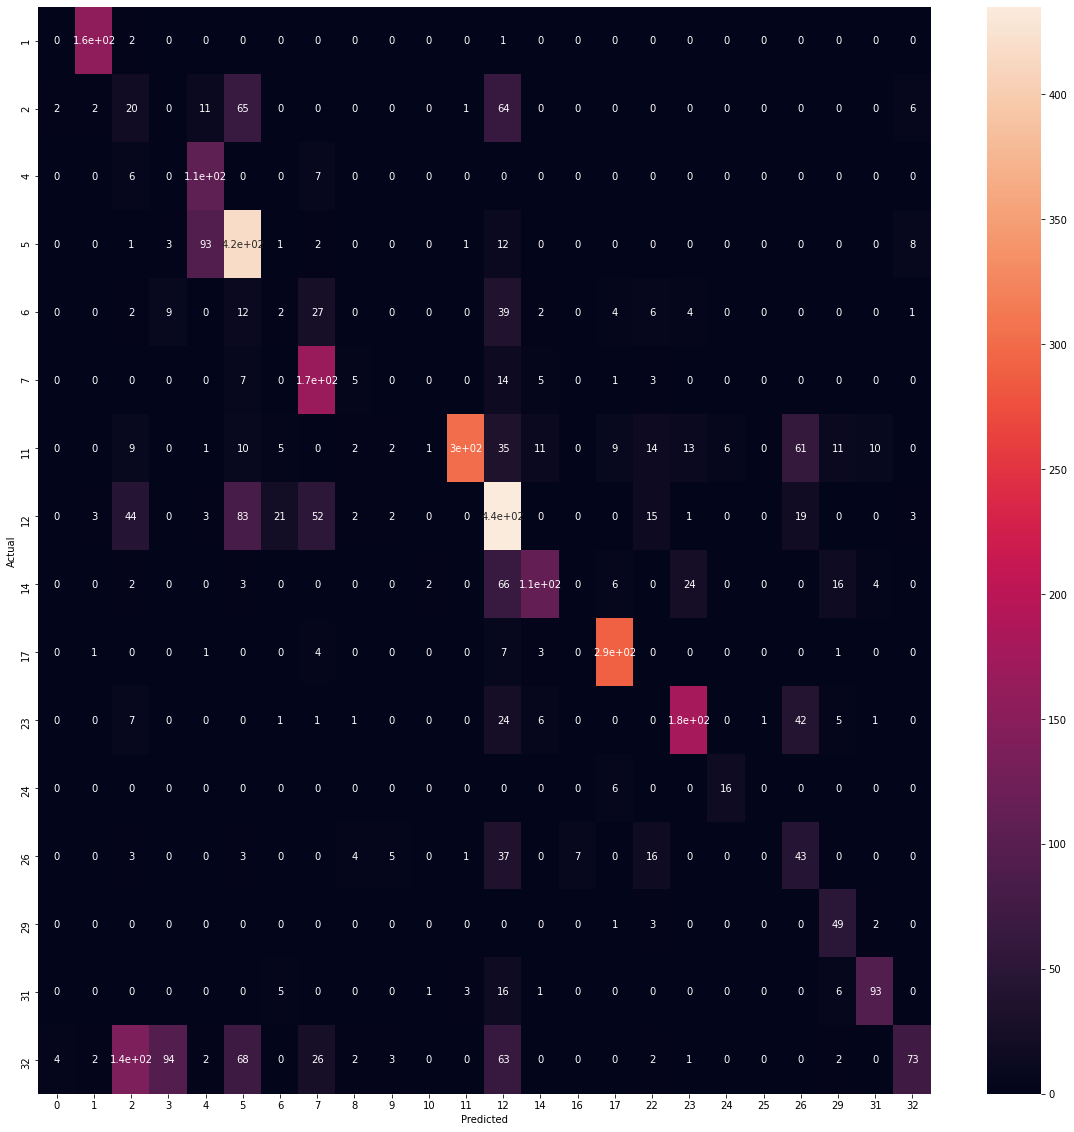

,y_Actual,y_Predicted
0,1,2
1,1,2
2,1,1
3,1,1
4,1,1
...,...,...
4091,32,22
4092,32,12
4093,32,2
4094,32,7


In [53]:
tf.math.confusion_matrix(
    labels, pred
)


<tf.Tensor: shape=(33, 33), dtype=int32, numpy=
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 10, 16, ...,  0,  1,  3],
       [ 0,  5, 11, ...,  0,  3,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  8,  5, ...,  0,  7,  3],
       [ 0, 23, 25, ...,  0, 22,  8]])>